In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import torch.nn as nn
from tbnn.training_utils import early_stopped_tbnn_training_run
import tbnn.dataloaders as dataloaders
import torch
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import tbnn.models as models
import tbnn.devices as devices
import tbnn.dataloaders as dataloaders
import tbnn.losses as losses
device = devices.get_device()
import numpy as np
import tbnn.training_utils as training_utils
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [2]:
dataset_params = {'file': '/home/ryley/WDK/ML/dataset/komegasst_split.csv',
                  'test_set': ['case_1p2'],
                }

df = pd.read_csv(dataset_params['file'])

df = df[df['Case'].isin(['case_1p0', 'case_0p8','case_1p2'])]

df_test = df[df['Case'].isin(dataset_params['test_set'])]
df_tv = df[~df['Case'].isin(dataset_params['test_set'])]
print(f'Dataset: {len(df)}, test: {len(df_test)}, tv: {len(df_tv)}')



Dataset: 44253, test: 14751, tv: 29502


[1 2 0 3]
CLUSTER: 1
Training points: 1370, validation points 1338
EPOCH    LR        TRAIN     VALID         MSE:T/V              RL:T/V         %NR_t/%NR_v
  1   3.000e-03   0.02886   0.03286   0.02886 / 0.02863   0.00000 / 0.00042   0.00% / 0.07%
 10   2.987e-03   0.02101   0.02472   0.02101 / 0.02048   0.00000 / 0.00042   0.00% / 2.09%
 20   2.972e-03   0.01709   0.02070   0.01704 / 0.01643   0.00000 / 0.00043   1.39% / 1.42%
 30   2.957e-03   0.01473   0.01827   0.01459 / 0.01390   0.00001 / 0.00044   4.82% / 6.13%
 40   2.942e-03   0.01377   0.01752   0.01341 / 0.01278   0.00004 / 0.00047   4.53% / 6.58%
 50   2.927e-03   0.01278   0.01646   0.01275 / 0.01217   0.00000 / 0.00043   3.72% / 5.23%
 60   2.913e-03   0.01188   0.01564   0.01188 / 0.01131   0.00000 / 0.00043   0.22% / 0.52%
 70   2.898e-03   0.01151   0.01537   0.01151 / 0.01100   0.00000 / 0.00044   0.51% / 0.90%
 80   2.884e-03   0.01161   0.01549   0.01159 / 0.01111   0.00000 / 0.00044   3.07% / 3.36%
 90   2.869e-0

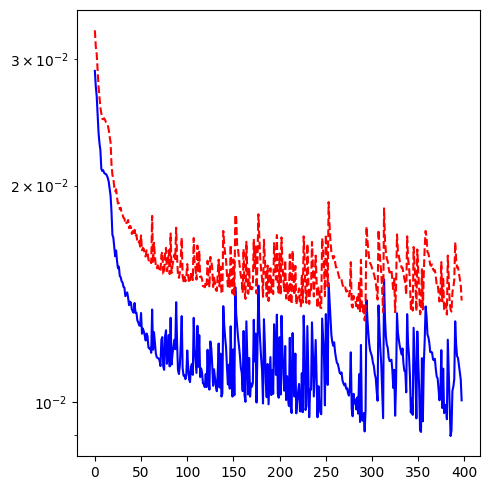

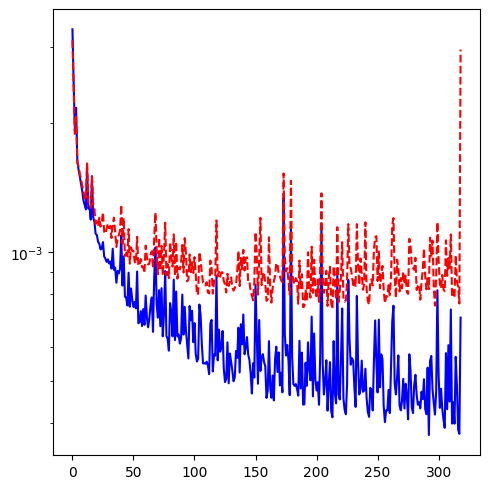

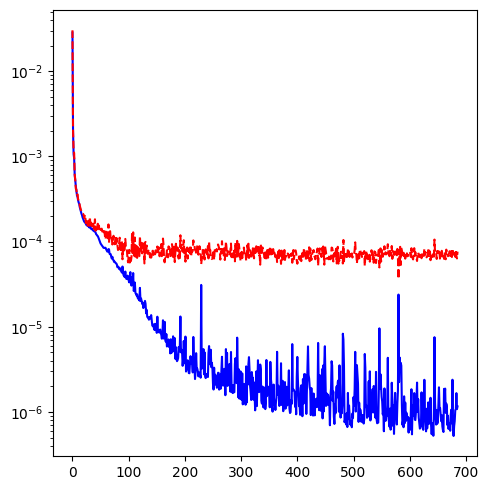

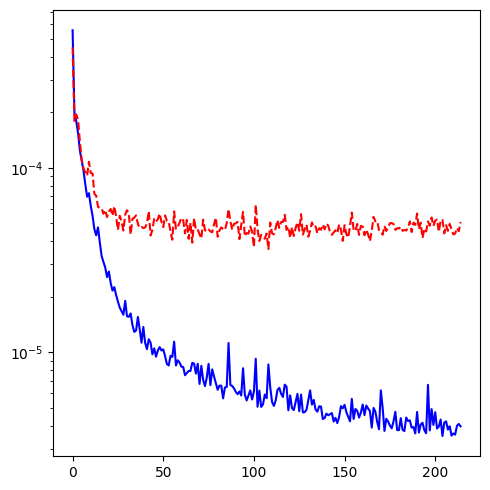

In [6]:
training_params = {'early_stopping_patience': 200,
                    'max_epochs': 3000,
                      'learning_rate': 0.003,
                        'learning_rate_decay': 0.9995,
                          'batch_size': 32,
                            'val_set': ['case_0p8']}

model_params = {'neurons': 20, 'n_hidden': 5, 'activation_function': nn.SiLU(),                 
                #'input_features': ['komegasst_q6','komegasst_q5','komegasst_I1_1','komegasst_I1_3','komegasst_I2_3','komegasst_I1_5']
                'input_features':['komegasst_I1_1',
'komegasst_I1_3',
'komegasst_I1_4',
'komegasst_I1_5',
#'komegasst_I1_16',
#'komegasst_I1_7',
#'komegasst_I1_9',
#'komegasst_I1_10',
#'komegasst_I1_12',
#'komegasst_I1_13',
#'komegasst_I1_16',
'komegasst_q5',
#'komegasst_q6',
]
}

df_test[f'pred_b_11_all'] = np.zeros(len(df_test))
df_test[f'pred_b_12_all'] = np.zeros(len(df_test))
df_test[f'pred_b_13_all'] = np.zeros(len(df_test))
df_test[f'pred_b_22_all'] = np.zeros(len(df_test))
df_test[f'pred_b_23_all'] = np.zeros(len(df_test))
df_test[f'pred_b_33_all'] = np.zeros(len(df_test))

cluster_models = dict.fromkeys(df_test['Cluster'].unique())
print(df_test['Cluster'].unique())
bperp_pred_test = np.zeros((len(df_test),3,3))
for cluster in df_test['Cluster'].unique():
    print(f'CLUSTER: {cluster}')
    df_tv = df[~df['Case'].isin(dataset_params['test_set'])]
    df_tv = df_tv[df_tv['Cluster']==cluster]
        
    model = models.TBNNPerpPlus(N = 10,
                    input_dim = len(model_params['input_features']),
                    n_hidden = model_params['n_hidden'],
                    neurons = model_params['neurons'],
                    activation_function = model_params['activation_function'],
                    input_feature_names=model_params['input_features']
                ).to(device)

    model, loss_vals, val_loss_vals  = early_stopped_tbnn_training_run(model = model,
                                                                      training_params = training_params,
                                                                      df_tv = df_tv,
                                                                      data_loader=dataloaders.bPerpDataset
                                                                      )
    
    fig, ax = plt.subplots(1,figsize=(5,5))
    ax.plot(loss_vals,'-',color='b')
    ax.plot(val_loss_vals,'--',color='r')
    ax.semilogy()
    fig.tight_layout()
    cluster_models[cluster] = model
    #fig.savefig(f'models/model_cluster_{cluster}.png',dpi=300)

    model.eval()
    df_train = df[~df['Case'].isin(dataset_params['test_set']+training_params['val_set'])]
    df_train = df_train[df_train['Cluster']==cluster]
    tDs = dataloaders.bPerpDataset(df_train, input_features=model_params['input_features'])
    testDs = dataloaders.bPerpDataset(df_test, input_features=model_params['input_features'],scaler_X = tDs.scaler_X)

    for X, T, y in DataLoader(testDs, shuffle=False, batch_size=testDs.__len__()):
        y_pred_test, gn = model(X,T)
        bperp_pred_test += df_test[f'Probability_cluster_{cluster}'].to_numpy()[:,None,None]*torch.sum(gn[:,1:11].view(-1,9,1,1)*torch.ones_like(T[:,1:11,:])*T[:,1:11,:],axis=1).detach().numpy()

        #print(f"loss: {losses.bLoss(y_pred_test,y)}")
        #print(f"loss: {losses.mseLoss(y_pred_test,y)}")
        #print(f"loss: {losses.realizabilityPenalty(y)}")
        #print(f"loss: {losses.realizabilityPenalty_components(y)}")
        #print(f"loss: {losses.realizabilityPenalty_eigs(y)}")


        #val_loss_values.append(loss_fn(y_pred_val,y).item())   
        #mse_v = mseLoss(y_pred_val,y).item()  
        #rl_v = realizLoss(y_pred_val,y).item()
    #for prediction_name in ['pred_b_11','pred_b_12','pred_b_13','pred_b_22','pred_b_23','pred_b_33']:
    #print(y_pred_test.shape)
    df_test[f'pred_b_11_all'] += y_pred_test[:,0,0].detach().numpy()*df_test[f'Probability_cluster_{cluster}']
    df_test[f'pred_b_12_all'] += y_pred_test.detach().numpy()[:,0,1]*df_test[f'Probability_cluster_{cluster}']
    df_test[f'pred_b_13_all'] += y_pred_test.detach().numpy()[:,0,2]*df_test[f'Probability_cluster_{cluster}']
    df_test[f'pred_b_22_all'] += y_pred_test.detach().numpy()[:,1,1]*df_test[f'Probability_cluster_{cluster}']
    df_test[f'pred_b_23_all'] += y_pred_test.detach().numpy()[:,1,2]*df_test[f'Probability_cluster_{cluster}']
    df_test[f'pred_b_33_all'] += y_pred_test.detach().numpy()[:,2,2]*df_test[f'Probability_cluster_{cluster}']

    df_test[f'pred_g1_model{cluster}'] = gn[:,0].detach().numpy()
    df_test[f'pred_g2_model{cluster}_model{cluster}'] = gn[:,1].detach().numpy()
    df_test[f'pred_g3_model{cluster}'] = gn[:,2].detach().numpy()
    df_test[f'pred_g4_model{cluster}'] = gn[:,3].detach().numpy()
    df_test[f'pred_g5_model{cluster}'] = gn[:,4].detach().numpy()
    df_test[f'pred_g6_model{cluster}'] = gn[:,5].detach().numpy()
    df_test[f'pred_g7_model{cluster}'] = gn[:,6].detach().numpy()
    df_test[f'pred_g8_model{cluster}'] = gn[:,7].detach().numpy()
    df_test[f'pred_g9_model{cluster}'] = gn[:,8].detach().numpy()
    df_test[f'pred_g10_model{cluster}'] = gn[:,9].detach().numpy()

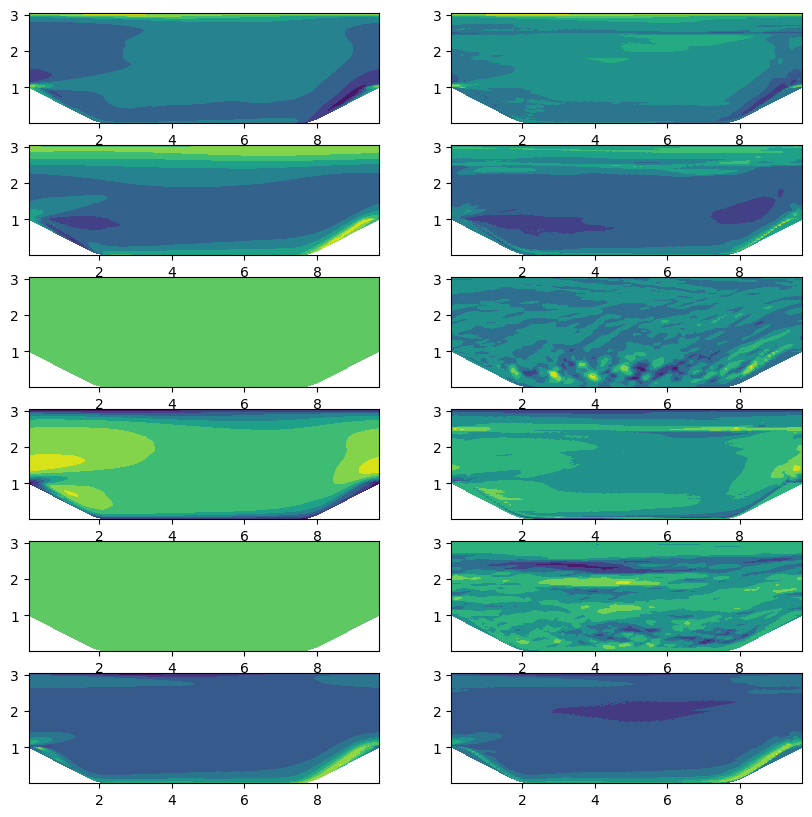

In [7]:
fig, axs = plt.subplots(nrows=6,ncols=2,figsize=(10,10))
axs[0,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_11'])
axs[0,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_11_all'])

axs[1,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_12'])
axs[1,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_12_all'])

axs[2,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_13'])
axs[2,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_13_all'])

axs[3,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_22'])
axs[3,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_22_all'])

axs[4,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_23'])
axs[4,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_23_all'])

axs[5,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_33'])
axs[5,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_33_all'])

for ax in axs.reshape(-1): 
    ax.set_aspect(1)


In [9]:
print(bperp_pred_test.shape)
print(T[:,1:11,:].shape)
k_DNS = np.load('/home/ryley/WDK/ML/dataset/numpy/DNS/DNS_case_1p2_k.npy')

aperp_pred = 2*k_DNS[:,None,None]*bperp_pred_test
print(aperp_pred.shape)

(14751, 3, 3)
torch.Size([14751, 9, 3, 3])
(14751, 3, 3)


In [10]:
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/ryley/WDK/ML/code/data_scripting/dataFoam')
from utilities.foamIO import writeFoam_PHLL

writeFoam_PHLL.writeFoam_ap_PHLL('/home/ryley/WDK/ML/scratch/injection/case_1p2_testing_models/0/aperp',aperp_pred)

Writing aperp to file /home/ryley/WDK/ML/scratch/injection/case_1p2_testing_models/0/aperp
